正在下载数据...
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  4 of 4 completed
/tmp/ipykernel_135542/698290635.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_135542/698290635.py:63: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


数据下载完成

=== 最后一天指标与评分 ===
日期: 2026-01-29
VIX: 19.57 | VIX_5MA: 16.90 | A2B阈值: 19 | B2A阈值: 23
DXY: 96.39 | DXY_5MA: 96.74 | A2B阈值: 99 | B2A阈值: 102
SP500_MA20: 689.70 | SP500_MA50: 682.25
Gold_MA20: 433.74 | Gold_MA50: 408.02
VIX_score: 0.000 | DXY_score: 0.000 | MA_score: 0.445 | GOLD_score: 0.315
Composite_score: 0.089
最后一天策略信号: 策略A(100%纳斯达克)

=== 调仓记录 ===
日期           从                                        到                                        VIX      DXY      VIX_5MA  DXY_5MA  类型        
----------------------------------------------------------------------------------------------------------------------------------
2022-04-13   策略A(100%纳斯达克)                            策略B(20%标普500+30%短期债券+50%黄金)              21.82    99.88    22.63    99.93    A转B       
2023-05-09   策略B(20%标普500+30%短期债券+50%黄金)              策略A(100%纳斯达克)                            17.71    101.64   18.06    101.39   B转A       
2023-07-10   策略A(100%纳斯达克)                            策略B(20%标普500+30%短期债券+50%黄金)   

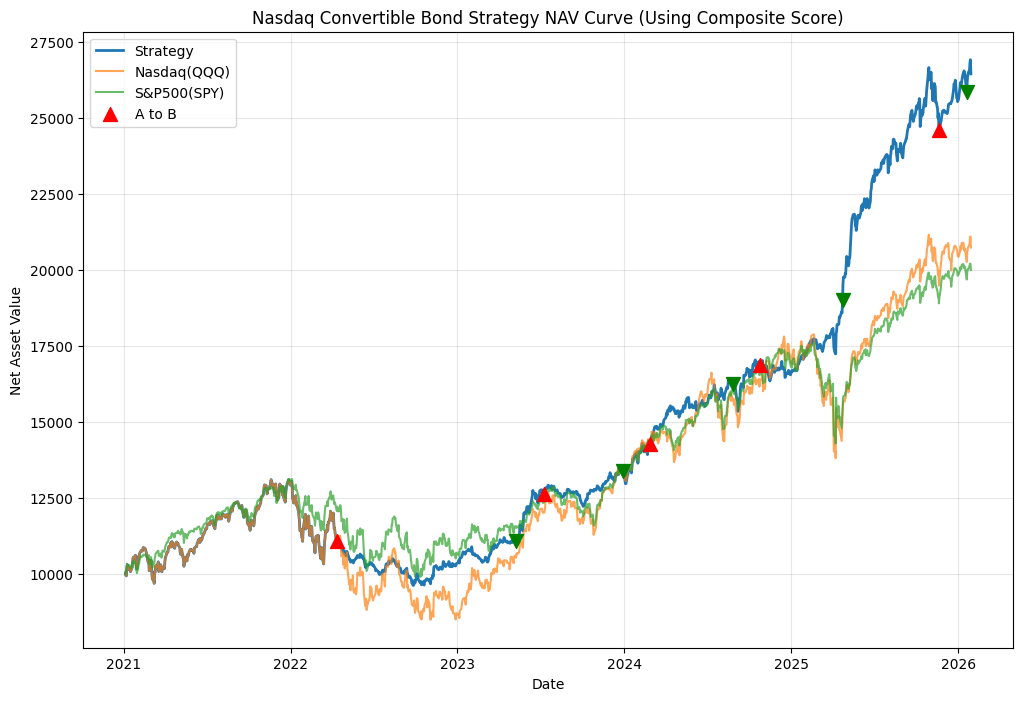

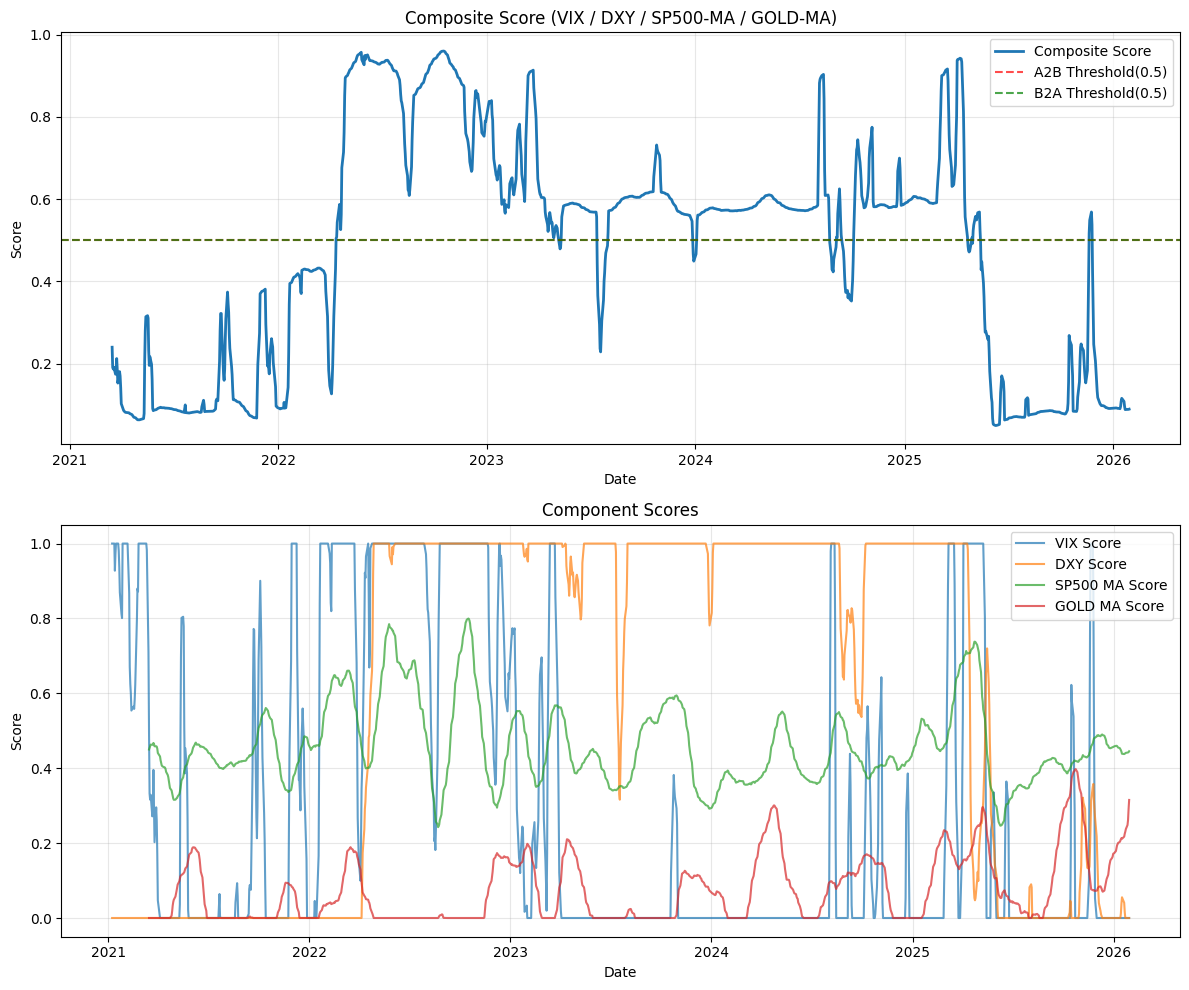

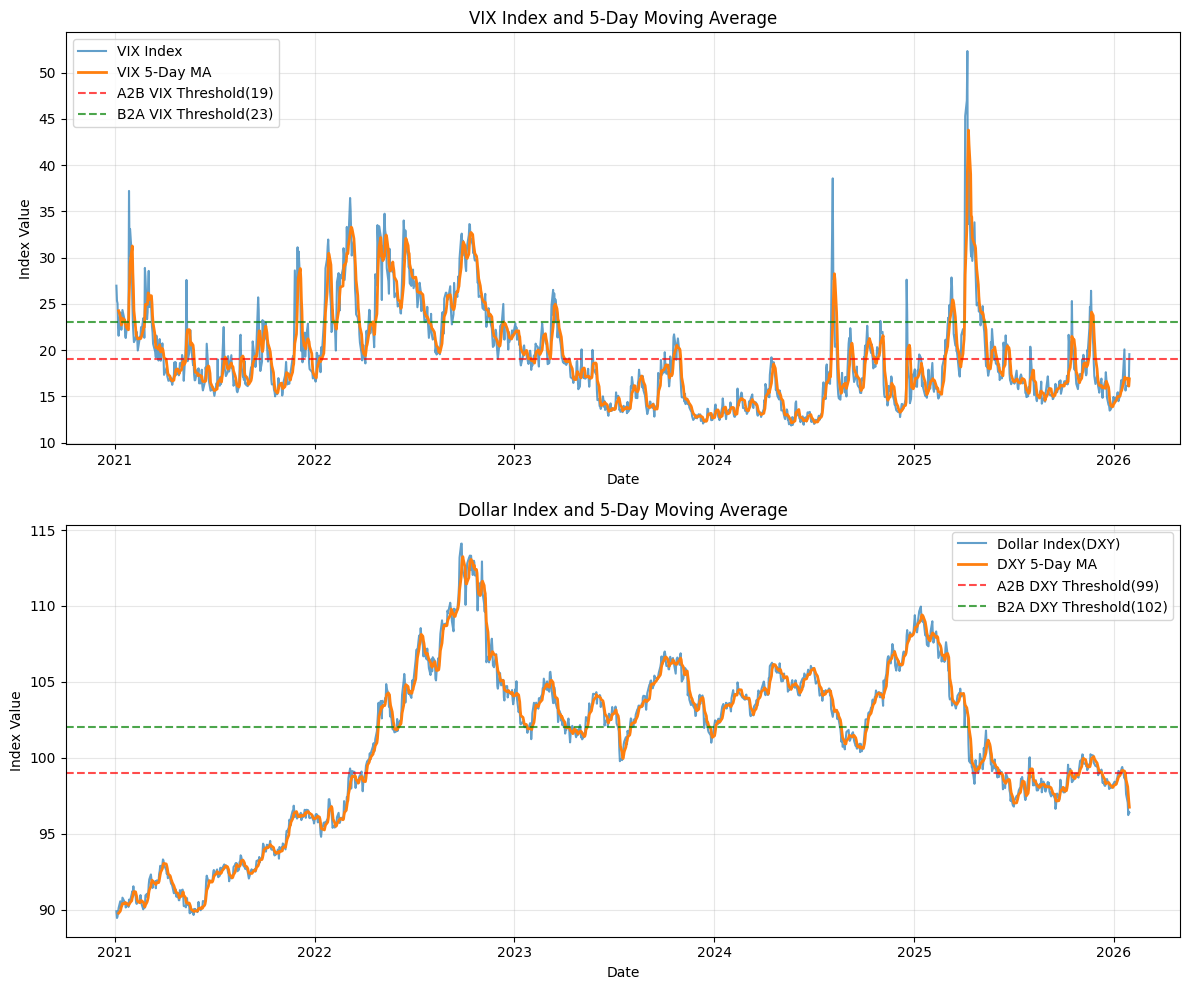

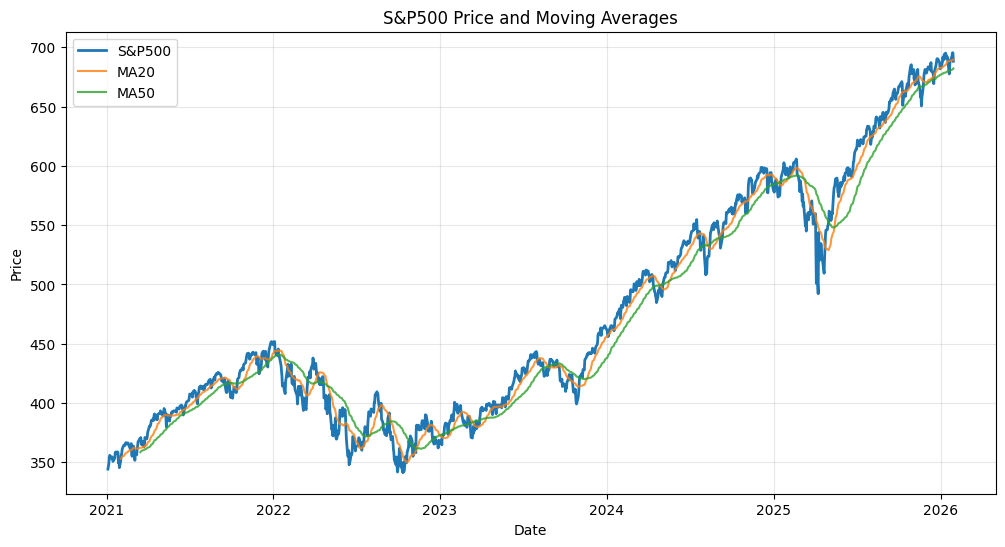

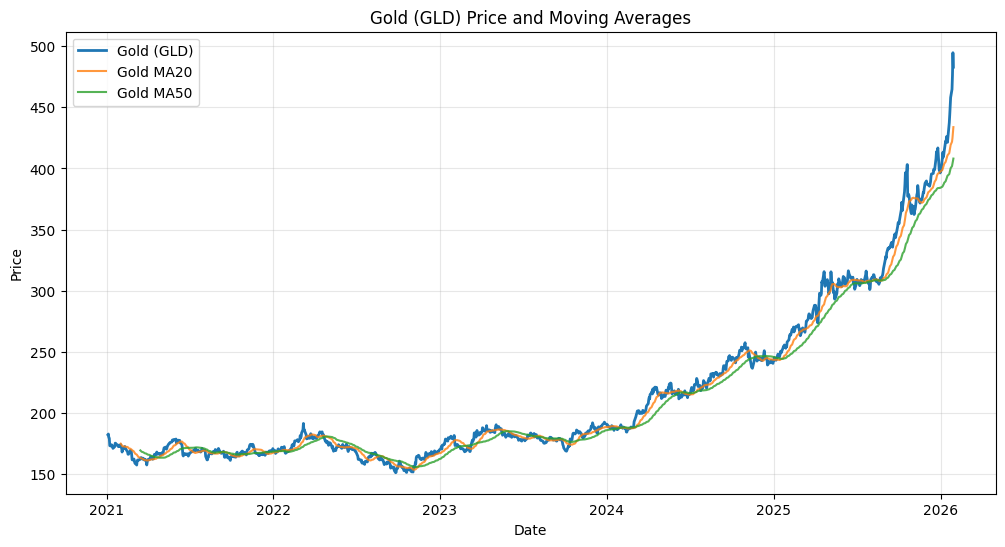

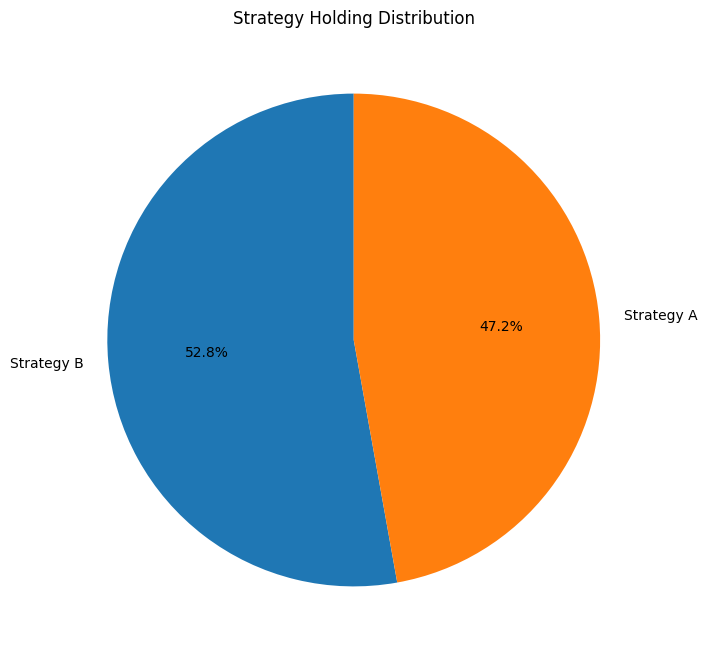


=== 策略参数 ===
VIX权重:  0.3
DXY权重:  0.5
MA权重:   0.2
GOLD权重: 0
A转B阈值: 综合评分 > 0.5
B转A阈值: 综合评分 < 0.5
冷却期: 60 天


In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# ================== 基本参数 ==================
start_date = "2021-01-01"
end_date = "2026-01-30"
initial_capital = 10000  # 初始资金

# 阈值（A->B 为防守触发，B->A 为进攻恢复）
VIX_THRESHOLD_A2B = 19
DXY_THRESHOLD_A2B = 99
VIX_THRESHOLD_B2A = 23
DXY_THRESHOLD_B2A = 102

# ======== 权重（合计=1）========
# 调整后加入 GOLD 权重；可按需改
VIX_WEIGHT  = 0.3
DXY_WEIGHT  = 0.5
MA_WEIGHT   = 0.2
GOLD_WEIGHT = 0

# 综合评分阈值
SCORE_THRESHOLD_A2B = 0.5
SCORE_THRESHOLD_B2A = 0.5

# 移动平均线周期
MA_SHORT_PERIOD = 20
MA_LONG_PERIOD  = 50

# 冷却期（注意这里是自然日）
COOLDOWN_PERIOD = 60

# 策略B配置
STRATEGY_B_ALLOCATION = {
    "SP500": 0.2,
    "Bonds_short": 0.3,
    "Gold": 0.5
}

# 资产代码
assets = {
    "SP500": "SPY",
    "Nasdaq": "QQQ",
    "Bonds_short": "SHY",
    "Gold": "GLD"
}

# ================== 下载与准备数据 ==================
print("正在下载数据...")
data = yf.download(list(assets.values()), start=start_date, end=end_date)["Close"]
data.rename(columns={v: k for k, v in assets.items()}, inplace=True)
data.fillna(method='ffill', inplace=True)

vix = yf.download('^VIX', start=start_date, end=end_date)["Close"]
dxy = yf.download('DX-Y.NYB', start=start_date, end=end_date)["Close"]

data['VIX'] = vix
data['DXY'] = dxy
data.fillna(method='ffill', inplace=True)

# 5日均值（VIX/DXY）
data['VIX_5MA'] = data['VIX'].rolling(window=5).mean()
data['DXY_5MA'] = data['DXY'].rolling(window=5).mean()

# SP500 均线
data['SP500_MA20'] = data['SP500'].rolling(window=MA_SHORT_PERIOD).mean()
data['SP500_MA50'] = data['SP500'].rolling(window=MA_LONG_PERIOD).mean()

# Gold 均线（用于避险情绪）
data['Gold_MA20'] = data['Gold'].rolling(window=MA_SHORT_PERIOD).mean()
data['Gold_MA50'] = data['Gold'].rolling(window=MA_LONG_PERIOD).mean()

print("数据下载完成")

# ================== 综合评分 ==================
def calculate_composite_score(data):
    scores = pd.DataFrame(index=data.index)

    # —— 风险分定义：越高越危险（越倾向防守B）——
    # VIX/DXY：A2B(安全)→0，B2A(危险)→1，线性映射并裁剪到[0,1]
    scores['VIX_score'] = (data['VIX_5MA'] - VIX_THRESHOLD_A2B) / (VIX_THRESHOLD_B2A - VIX_THRESHOLD_A2B)
    scores['VIX_score'] = scores['VIX_score'].clip(0, 1)

    scores['DXY_score'] = (data['DXY_5MA'] - DXY_THRESHOLD_A2B) / (DXY_THRESHOLD_B2A - DXY_THRESHOLD_A2B)
    scores['DXY_score'] = scores['DXY_score'].clip(0, 1)

    # SP500 趋势（MA20/MA50 越低越危险）：与你原始写法保持一致
    ma_ratio = data['SP500_MA20'] / data['SP500_MA50']
    scores['MA_score'] = 1 - (ma_ratio - 0.9) / (1.1 - 0.9)
    scores['MA_score'] = scores['MA_score'].clip(0, 1)

    # GOLD 避险分：当黄金短期相对长期越强（MA20/MA50 > 1）→ 避险升温 → 风险分上升
    gold_ratio = data['Gold_MA20'] / data['Gold_MA50']
    # 以 1.0 为临界点，1.0~1.1 映射到 0~1（>1.1 视作饱和）；<1 则裁剪为 0
    scores['GOLD_score'] = (gold_ratio - 1.0) / (1.2 - 1.0)
    scores['GOLD_score'] = scores['GOLD_score'].clip(0, 1)

    # 综合风险分
    scores['Composite_score'] = (
        scores['VIX_score']  * VIX_WEIGHT  +
        scores['DXY_score']  * DXY_WEIGHT  +
        scores['MA_score']   * MA_WEIGHT   +
        scores['GOLD_score'] * GOLD_WEIGHT
    )

    return scores

# ================== 信号 ==================
def calculate_signals(data):
    signals = pd.DataFrame(index=data.index)

    scores = calculate_composite_score(data)

    # A->B：风险分高于阈值；B->A：风险分低于阈值
    signals['A2B_condition'] = scores['Composite_score'] > SCORE_THRESHOLD_A2B
    signals['B2A_condition'] = scores['Composite_score'] < SCORE_THRESHOLD_B2A

    signals['Strategy_A'] = signals['B2A_condition']  # 低风险
    signals['Strategy_B'] = signals['A2B_condition']  # 高风险

    signals['Raw_Signal'] = 0
    signals.loc[signals['Strategy_A'].shift(1) == True, 'Raw_Signal'] = 1
    signals.loc[signals['Strategy_B'].shift(1) == True, 'Raw_Signal'] = 2

    # 冷却期
    signals['Final_Signal'] = 0
    last_transition_date = None

    for i in range(len(signals)):
        current_date = signals.index[i]
        if i == 0:
            signals.iloc[i, signals.columns.get_loc('Final_Signal')] = 1
            continue

        raw_signal = signals['Raw_Signal'].iloc[i]
        if last_transition_date and (current_date - last_transition_date).days < COOLDOWN_PERIOD:
            signals.iloc[i, signals.columns.get_loc('Final_Signal')] = signals['Final_Signal'].iloc[i-1]
            continue

        if raw_signal != 0 and raw_signal != signals['Final_Signal'].iloc[i-1]:
            signals.iloc[i, signals.columns.get_loc('Final_Signal')] = raw_signal
            last_transition_date = current_date
        else:
            signals.iloc[i, signals.columns.get_loc('Final_Signal')] = signals['Final_Signal'].iloc[i-1]

    return signals['Final_Signal'], scores

# ================== 收益计算 ==================
def calculate_returns(data, signals):
    returns = pd.DataFrame(index=data.index)

    for asset in assets.keys():
        returns[f'{asset}_Return'] = data[asset].pct_change()

    strategy_returns = []
    current_strategy = 1
    rebalance_records = []
    last_transition_date = None

    strategy_b_desc = f"策略B({STRATEGY_B_ALLOCATION['SP500']*100:.0f}%标普500+{STRATEGY_B_ALLOCATION['Bonds_short']*100:.0f}%短期债券+{STRATEGY_B_ALLOCATION['Gold']*100:.0f}%黄金)"

    for i in range(len(returns)):
        if i == 0:
            strategy_returns.append(0)
            continue

        if not pd.isna(signals.iloc[i]):
            previous_strategy = current_strategy
            current_strategy = signals.iloc[i]

            if previous_strategy != current_strategy:
                date = returns.index[i]

                if last_transition_date and (date - last_transition_date).days < COOLDOWN_PERIOD:
                    current_strategy = previous_strategy
                    strategy_returns.append(strategy_returns[-1])
                    continue

                last_transition_date = date

                from_strategy = "策略A(100%纳斯达克)" if previous_strategy == 1 else strategy_b_desc
                to_strategy   = "策略A(100%纳斯达克)" if current_strategy == 1 else strategy_b_desc

                vix_value = data['VIX'].iloc[i]
                dxy_value = data['DXY'].iloc[i]
                vix_5ma   = data['VIX_5MA'].iloc[i]
                dxy_5ma   = data['DXY_5MA'].iloc[i]

                transition_type = "A转B" if (previous_strategy == 1 and current_strategy == 2) else ("B转A" if (previous_strategy == 2 and current_strategy == 1) else "")

                rebalance_records.append({
                    'Date': date,
                    'From': from_strategy,
                    'To': to_strategy,
                    'VIX': vix_value,
                    'DXY': dxy_value,
                    'VIX_5MA': vix_5ma,
                    'DXY_5MA': dxy_5ma,
                    'Type': transition_type
                })

        if current_strategy == 1:  # A：100% QQQ
            strategy_returns.append(returns['Nasdaq_Return'].iloc[i])
        elif current_strategy == 2:  # B：分散配置
            spy_return = returns['SP500_Return'].iloc[i]       * STRATEGY_B_ALLOCATION['SP500']
            shy_return = returns['Bonds_short_Return'].iloc[i] * STRATEGY_B_ALLOCATION['Bonds_short']
            gld_return = returns['Gold_Return'].iloc[i]        * STRATEGY_B_ALLOCATION['Gold']
            strategy_returns.append(spy_return + shy_return + gld_return)
        else:
            strategy_returns.append(0)

    returns['Strategy_Return'] = strategy_returns
    returns['Strategy_Cumulative'] = (1 + returns['Strategy_Return']).cumprod()

    return returns, rebalance_records

# ================== 指标 ==================
def calculate_metrics(returns, risk_free_rate=0.02):
    metrics = {}

    total_days = len(returns)
    years = total_days / 252
    cumulative_return = returns['Strategy_Cumulative'].iloc[-1] - 1
    metrics['累计收益率'] = cumulative_return
    metrics['年化收益率'] = (1 + cumulative_return) ** (1/years) - 1

    returns['Year'] = returns.index.year
    yearly_returns = returns.groupby('Year')['Strategy_Return'].apply(lambda x: (1 + x).prod() - 1)
    metrics['年度收益'] = yearly_returns

    metrics['年化波动率'] = returns['Strategy_Return'].std() * np.sqrt(252)

    excess_returns = returns['Strategy_Return'] - risk_free_rate/252
    metrics['夏普比率'] = excess_returns.mean() / excess_returns.std() * np.sqrt(252)

    cumulative = returns['Strategy_Cumulative']
    peak = cumulative.expanding(min_periods=1).max()
    drawdown = (cumulative - peak) / peak
    metrics['最大回撤'] = drawdown.min()

    spy_returns = returns['SP500_Return']
    strategy_returns = returns['Strategy_Return']

    valid_idx = ~np.isnan(strategy_returns) & ~np.isnan(spy_returns)
    strategy_returns_valid = strategy_returns[valid_idx]
    spy_returns_valid = spy_returns[valid_idx]

    covariance = np.cov(strategy_returns_valid, spy_returns_valid)[0, 1]
    spy_variance = np.var(spy_returns_valid)

    beta = covariance / spy_variance
    alpha = (strategy_returns_valid.mean() - risk_free_rate/252) - beta * (spy_returns_valid.mean() - risk_free_rate/252)
    metrics['Alpha'] = alpha * 252
    metrics['Beta'] = beta

    return metrics, cumulative_return

# ================== 执行回测 ==================
signals, scores = calculate_signals(data)
returns, rebalance_records = calculate_returns(data, signals)
metrics, cumulative_return = calculate_metrics(returns)

# ===== 最后一天信息 =====
def signal_to_text(x: int) -> str:
    if x == 1:
        return "策略A(100%纳斯达克)"
    elif x == 2:
        return f"策略B({STRATEGY_B_ALLOCATION['SP500']*100:.0f}%标普500+{STRATEGY_B_ALLOCATION['Bonds_short']*100:.0f}%短债+{STRATEGY_B_ALLOCATION['Gold']*100:.0f}%黄金)"
    else:
        return "无信号/现金"

last_date = data.index[-1]
last_vix   = float(data.loc[last_date, 'VIX'])
last_dxy   = float(data.loc[last_date, 'DXY'])
last_vix_5 = float(data.loc[last_date, 'VIX_5MA'])
last_dxy_5 = float(data.loc[last_date, 'DXY_5MA'])
last_ma20  = float(data.loc[last_date, 'SP500_MA20'])
last_ma50  = float(data.loc[last_date, 'SP500_MA50'])
last_gma20 = float(data.loc[last_date, 'Gold_MA20'])
last_gma50 = float(data.loc[last_date, 'Gold_MA50'])

last_vix_score  = float(scores.loc[last_date, 'VIX_score'])
last_dxy_score  = float(scores.loc[last_date, 'DXY_score'])
last_ma_score   = float(scores.loc[last_date, 'MA_score'])
last_gold_score = float(scores.loc[last_date, 'GOLD_score'])
last_comp       = float(scores.loc[last_date, 'Composite_score'])

last_sig_val = int(signals.loc[last_date])
last_sig_txt = signal_to_text(last_sig_val)

print("\n=== 最后一天指标与评分 ===")
print(f"日期: {last_date.strftime('%Y-%m-%d')}")
print(f"VIX: {last_vix:.2f} | VIX_5MA: {last_vix_5:.2f} | A2B阈值: {VIX_THRESHOLD_A2B} | B2A阈值: {VIX_THRESHOLD_B2A}")
print(f"DXY: {last_dxy:.2f} | DXY_5MA: {last_dxy_5:.2f} | A2B阈值: {DXY_THRESHOLD_A2B} | B2A阈值: {DXY_THRESHOLD_B2A}")
print(f"SP500_MA20: {last_ma20:.2f} | SP500_MA50: {last_ma50:.2f}")
print(f"Gold_MA20: {last_gma20:.2f} | Gold_MA50: {last_gma50:.2f}")
print(f"VIX_score: {last_vix_score:.3f} | DXY_score: {last_dxy_score:.3f} | MA_score: {last_ma_score:.3f} | GOLD_score: {last_gold_score:.3f}")
print(f"Composite_score: {last_comp:.3f}")
print(f"最后一天策略信号: {last_sig_txt}")

# ================== 调仓记录打印 ==================
print("\n=== 调仓记录 ===")
print(f"{'日期':<12} {'从':<40} {'到':<40} {'VIX':<8} {'DXY':<8} {'VIX_5MA':<8} {'DXY_5MA':<8} {'类型':<10}")
print("-" * 130)
for record in rebalance_records:
    print(f"{record['Date'].strftime('%Y-%m-%d'):<12} {record['From']:<40} {record['To']:<40} {record['VIX']:<8.2f} {record['DXY']:<8.2f} {record['VIX_5MA']:<8.2f} {record['DXY_5MA']:<8.2f} {record['Type']:<10}")

# ================== 汇总结果 ==================
print("\n=== 策略回测结果 ===")
print(f"回测期间: {start_date} 至 {end_date}")
print(f"初始资金: ${initial_capital:,.2f}")
print(f"最终价值: ${initial_capital * (1 + cumulative_return):,.2f}")
print(f"累计收益率: {cumulative_return*100:.2f}%")
print(f"年化收益率: {metrics['年化收益率']*100:.2f}%")
print(f"年化波动率: {metrics['年化波动率']*100:.2f}%")
print(f"夏普比率: {metrics['夏普比率']:.2f}")
print(f"最大回撤: {metrics['最大回撤']*100:.2f}%")
print(f"Alpha: {metrics['Alpha']*100:.2f}%")
print(f"Beta: {metrics['Beta']:.2f}")

print("\n年度收益:")
for year, ret in metrics['年度收益'].items():
    print(f"{year}: {ret*100:.2f}%")

# ================== 绘图 ==================
# NAV
plt.figure(figsize=(12, 8))
plt.plot(returns.index, returns['Strategy_Cumulative'] * initial_capital, label='Strategy', linewidth=2)
plt.plot(returns.index, data['Nasdaq'] / data['Nasdaq'].iloc[0] * initial_capital, label='Nasdaq(QQQ)', alpha=0.7)
plt.plot(returns.index, data['SP500'] / data['SP500'].iloc[0] * initial_capital, label='S&P500(SPY)', alpha=0.7)

for record in rebalance_records:
    date = record['Date']
    value = returns.loc[date, 'Strategy_Cumulative'] * initial_capital
    if record['Type'] == 'A转B':
        color = 'red'; marker = '^'; label = 'A to B'
    elif record['Type'] == 'B转A':
        color = 'green'; marker = 'v'; label = 'B to A'
    else:
        continue
    plt.scatter(date, value, color=color, marker=marker, s=100, zorder=5,
                label=label if date == rebalance_records[0]['Date'] else "")

plt.title('Nasdaq Convertible Bond Strategy NAV Curve (Using Composite Score)')
plt.xlabel('Date'); plt.ylabel('Net Asset Value')
plt.legend(); plt.grid(True, alpha=0.3)
plt.show()

# 综合分
plt.figure(figsize=(12, 10))
plt.subplot(2, 1, 1)
plt.plot(scores.index, scores['Composite_score'], label='Composite Score', linewidth=2)
plt.axhline(y=SCORE_THRESHOLD_A2B, color='r', linestyle='--', alpha=0.7, label=f'A2B Threshold({SCORE_THRESHOLD_A2B})')
plt.axhline(y=SCORE_THRESHOLD_B2A, color='g', linestyle='--', alpha=0.7, label=f'B2A Threshold({SCORE_THRESHOLD_B2A})')
plt.title('Composite Score (VIX / DXY / SP500-MA / GOLD-MA)')
plt.xlabel('Date'); plt.ylabel('Score')
plt.legend(); plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.plot(scores.index, scores['VIX_score'],   label='VIX Score',  alpha=0.7)
plt.plot(scores.index, scores['DXY_score'],   label='DXY Score',  alpha=0.7)
plt.plot(scores.index, scores['MA_score'],    label='SP500 MA Score', alpha=0.7)
plt.plot(scores.index, scores['GOLD_score'],  label='GOLD MA Score',  alpha=0.7)
plt.title('Component Scores')
plt.xlabel('Date'); plt.ylabel('Score')
plt.legend(); plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

# VIX / DXY
plt.figure(figsize=(12, 10))
plt.subplot(2, 1, 1)
plt.plot(data.index, data['VIX'],     label='VIX Index', alpha=0.7)
plt.plot(data.index, data['VIX_5MA'], label='VIX 5-Day MA', linewidth=2)
plt.axhline(y=VIX_THRESHOLD_A2B, color='r', linestyle='--', alpha=0.7, label=f'A2B VIX Threshold({VIX_THRESHOLD_A2B})')
plt.axhline(y=VIX_THRESHOLD_B2A, color='g', linestyle='--', alpha=0.7, label=f'B2A VIX Threshold({VIX_THRESHOLD_B2A})')
plt.title('VIX Index and 5-Day Moving Average'); plt.xlabel('Date'); plt.ylabel('Index Value')
plt.legend(); plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.plot(data.index, data['DXY'],     label='Dollar Index(DXY)', alpha=0.7)
plt.plot(data.index, data['DXY_5MA'], label='DXY 5-Day MA', linewidth=2)
plt.axhline(y=DXY_THRESHOLD_A2B, color='r', linestyle='--', alpha=0.7, label=f'A2B DXY Threshold({DXY_THRESHOLD_A2B})')
plt.axhline(y=DXY_THRESHOLD_B2A, color='g', linestyle='--', alpha=0.7, label=f'B2A DXY Threshold({DXY_THRESHOLD_B2A})')
plt.title('Dollar Index and 5-Day Moving Average'); plt.xlabel('Date'); plt.ylabel('Index Value')
plt.legend(); plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

# SP500 均线
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['SP500'], label='S&P500', linewidth=2)
plt.plot(data.index, data['SP500_MA20'], label=f'MA{MA_SHORT_PERIOD}', alpha=0.8)
plt.plot(data.index, data['SP500_MA50'], label=f'MA{MA_LONG_PERIOD}',  alpha=0.8)
plt.title('S&P500 Price and Moving Averages'); plt.xlabel('Date'); plt.ylabel('Price')
plt.legend(); plt.grid(True, alpha=0.3)
plt.show()

# Gold 均线
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Gold'], label='Gold (GLD)', linewidth=2)
plt.plot(data.index, data['Gold_MA20'], label='Gold MA20', alpha=0.8)
plt.plot(data.index, data['Gold_MA50'], label='Gold MA50', alpha=0.8)
plt.title('Gold (GLD) Price and Moving Averages'); plt.xlabel('Date'); plt.ylabel('Price')
plt.legend(); plt.grid(True, alpha=0.3)
plt.show()

# 持仓分布
strategy_days = pd.Series(signals).value_counts()
plt.figure(figsize=(8, 8))
labels = ['Strategy A' if x == 1 else 'Strategy B' if x == 2 else 'Cash' for x in strategy_days.index]
plt.pie(strategy_days.values, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Strategy Holding Distribution')
plt.show()

# 参数打印
print("\n=== 策略参数 ===")
print(f"VIX权重:  {VIX_WEIGHT}")
print(f"DXY权重:  {DXY_WEIGHT}")
print(f"MA权重:   {MA_WEIGHT}")
print(f"GOLD权重: {GOLD_WEIGHT}")
print(f"A转B阈值: 综合评分 > {SCORE_THRESHOLD_A2B}")
print(f"B转A阈值: 综合评分 < {SCORE_THRESHOLD_B2A}")
print(f"冷却期: {COOLDOWN_PERIOD} 天")
